In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "TRB_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-BMC-TRB_HUMAN-after-reassignment.csv',
 'cdr3-clones-DOMINO-TRB_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20201116-RUN40-DataSheet.csv"
run = "run40"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: run40-similarity-TRB_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,BMC110-1-TuH_S1,ACGTACGT,CSVTDGPNQPQHFG,1135,825,TRBV29-1,TRBJ1-5,2261,1.992070,3.447124,3.013589
1,BMC110-1-TuH_S1,ACGTACGT,CSVQQGVRDEQYFG,995,770,TRBV29-1,"TRBJ2-7,TRBJ2-5,TRBJ2-1",1981,1.990955,3.021928,2.812683
2,BMC110-1-TuH_S1,ACGTACGT,CSAGGDRGLHEQYFG,863,648,TRBV29-1,"TRBJ2-7,TRBJ2-1,TRBJ2-5",1718,1.990730,2.621029,2.367037
3,BMC110-1-TuH_S1,ACGTACGT,CASSYSETGGEDYGYTFG,293,256,TRBV6-2+TRBV6-3,TRBJ1-2,282,0.962457,0.889874,0.935126
4,BMC110-1-TuH_S1,ACGTACGT,CASSYGTSGKYEQFFG,268,235,TRBV6-5,"TRBJ2-1,TRBJ2-7",263,0.981343,0.813946,0.858416


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
1180347,DO-041V0-Tu_S238,CASSLYWDRGEEQYFG,511,461,509,0.996086,2.035208,2.009853
1177630,DO-041V0-Tu_S238,CASSHGPSYGYTFG,76,71,76,1.000000,0.302692,0.309544
1188416,DO-041V0-Tu_S238,CSVEDRTAFYGYTFG,75,72,152,2.026667,0.298710,0.313903
1176978,DO-041V0-Tu_S238,CASSFG,72,68,65,0.902778,0.286761,0.296464
1178768,DO-041V0-Tu_S238,CASSLGGGPAGIQYFG,66,58,66,1.000000,0.262864,0.252867


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,...,Species,Chain,Patient,SampleInfo,UMI,Group,HEK cells,RACE,Constant,ChainOrig
0,N711_S502,A11-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S9,...,mouse,BCRh,A1,Spleen-day21,no,VERA,yes,no,no,mBCRh
1,N712_S502,A12-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S10,...,mouse,BCRh,A2,Spleen-day21,no,VERA,yes,no,no,mBCRh
2,N714_S502,A13-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S11,...,mouse,BCRh,A3,Spleen-day21,no,VERA,yes,no,no,mBCRh
3,N715_S502,A14-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S12,...,mouse,BCRh,A4,Spleen-day21,no,VERA,yes,no,no,mBCRh
4,N716_S502,A15-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S13,...,mouse,BCRh,A5,Spleen-day21,no,VERA,yes,no,no,mBCRh


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,A11-Bh_S9,A1
1,A12-Bh_S10,A2
2,A13-Bh_S11,A3
3,A14-Bh_S12,A4
4,A15-Bh_S13,A5


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,DO-041V0-Tu_S238,CASSLYWDRGEEQYFG,511,461,509,0.996086,2.035208,2.009853,DO-041V0
1,DO-041V0-Tu_S238,CASSHGPSYGYTFG,76,71,76,1.000000,0.302692,0.309544,DO-041V0
2,DO-041V0-Tu_S238,CSVEDRTAFYGYTFG,75,72,152,2.026667,0.298710,0.313903,DO-041V0
3,DO-041V0-Tu_S238,CASSFG,72,68,65,0.902778,0.286761,0.296464,DO-041V0
4,DO-041V0-Tu_S238,CASSLGGGPAGIQYFG,66,58,66,1.000000,0.262864,0.252867,DO-041V0


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                   BMC110                          BMC111  \
Sample           BMC110-1-TuH_S1 BMC110-2-TuH_S2 BMC111-1-TuH_S3   
cdr3pep                                                            
CAAAAETGPNEQFFG              0.0             0.0             0.0   
CAAAAGDTGELFFG               0.0             0.0             0.0   
CAAAAGFSYEQYFG               0.0             0.0             0.0   
CAAAAGLGAYNEQFFG             0.0             0.0             0.0   
CAAAALNQPQHFG                0.0             0.0             0.0   

Patient                                   BMC116                  \
Sample           BMC111-2-TuH_S4 BMC116-1-TuH_S5 BMC116-2-TuH_S6   
cdr3pep                                                            
CAAAAETGPNEQFFG              0.0             0.0             0.0   
CAAAAGDTGELFFG               0.0             0.0             0.0   
CAAAAGFSYEQYFG               1.0             0.0             0.0   
CAAAAGLGAYNEQFFG             0.0             0.0             0.0   
CAAAALNQPQHFG                0.0             0.0             0.0   

Patient                   BMC132                           BMC140  \
Sample           BMC132-1-TuH_S7 BMC132-2-TuH_S8 BMC140-1-TuH_S25   
cdr3pep                                                             
CAAAAETGPNEQFFG              0.0             0.0              0.0   
CAAAAGDTGELFFG               0.0             0.0              0.0   
CAAAAGFSYEQYFG               0.0             0.0              0.0   
CAAAAGLGAYNEQFFG             0.0             0.0              0.0   
CAAAALNQPQHFG                0.0             0.0              0.0   

Patient                                 ...                   BMC326  \
Sample           BMC140-2-TuH_S26       ...        BMC326-1-TuH_S213   
cdr3pep                                 ...                            
CAAAAETGPNEQFFG               0.0       ...                      0.0   
CAAAAGDTGELFFG                0.0       ...                      0.0   
CAAAAGFSYEQYFG                0.0       ...                      0.0   
CAAAAGLGAYNEQFFG              0.0       ...                      0.0   
CAAAALNQPQHFG                 0.0       ...                      0.0   

Patient                     BMC327            BMC328            BMC329  \
Sample           BMC327-1-TuH_S214 BMC328-1-TuH_S215 BMC329-1-TuH_S232   
cdr3pep                                                                  
CAAAAETGPNEQFFG                0.0               0.0               0.0   
CAAAAGDTGELFFG                 0.0               0.0               0.0   
CAAAAGFSYEQYFG                 0.0               0.0               0.0   
CAAAAGLGAYNEQFFG               0.0               0.0               0.0   
CAAAALNQPQHFG                  0.0               0.0               0.0   

Patient                  DO-017V0         DO-021V0         DO-023V0  \
Sample           DO-017V0-Tu_S233 DO-021V0-Tu_S234 DO-023V0-Tu_S235   
cdr3pep                                                               
CAAAAETGPNEQFFG               0.0              0.0              0.0   
CAAAAGDTGELFFG                0.0              0.0              0.0   
CAAAAGFSYEQYFG                0.0              0.0              0.0   
CAAAAGLGAYNEQFFG              0.0              1.0              0.0   
CAAAALNQPQHFG                 0.0              0.0              0.0   

Patient                  DO-029V0         DO-036V0         DO-041V0  
Sample           DO-029V0-Tu_S236 DO-036V0-Tu_S237 DO-041V0-Tu_S238  
cdr3pep                                                              
CAAAAETGPNEQFFG               0.0              0.0              0.0  
CAAAAGDTGELFFG                0.0              0.0              0.0  
CAAAAGFSYEQYFG                0.0              0.0              0.0  
CAAAAGLGAYNEQFFG              0.0              0.0              0.0  
CAAAALNQPQHFG                 0.0              0.0              0.0  

[5 rows x 87 columns]

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                          BMC110                          BMC111  \
Sample                  BMC110-1-TuH_S1 BMC110-2-TuH_S2 BMC111-1-TuH_S3   
Patient Sample                                                            
BMC110  BMC110-1-TuH_S1        1.000000        0.211891        0.007201   
        BMC110-2-TuH_S2        0.211891        1.000000        0.003986   
BMC111  BMC111-1-TuH_S3        0.007201        0.003986        1.000000   
        BMC111-2-TuH_S4        0.006055        0.004574        0.274294   
BMC116  BMC116-1-TuH_S5        0.006653        0.005247        0.005661   

Patient                                          BMC116                  \
Sample                  BMC111-2-TuH_S4 BMC116-1-TuH_S5 BMC116-2-TuH_S6   
Patient Sample                                                            
BMC110  BMC110-1-TuH_S1        0.006055        0.006653        0.007872   
        BMC110-2-TuH_S2        0.004574        0.005247        0.005178   
BMC111  BMC111-1-TuH_S3        0.274294        0.005661        0.006963   
        BMC111-2-TuH_S4        1.000000        0.004437        0.004966   
BMC116  BMC116-1-TuH_S5        0.004437        1.000000        0.134474   

Patient                          BMC132                           BMC140  \
Sample                  BMC132-1-TuH_S7 BMC132-2-TuH_S8 BMC140-1-TuH_S25   
Patient Sample                                                             
BMC110  BMC110-1-TuH_S1        0.007561        0.007330         0.011809   
        BMC110-2-TuH_S2        0.005140        0.005073         0.006885   
BMC111  BMC111-1-TuH_S3        0.005929        0.006109         0.008693   
        BMC111-2-TuH_S4        0.004804        0.004020         0.007028   
BMC116  BMC116-1-TuH_S5        0.004985        0.003678         0.008778   

Patient                                        ...                   BMC326  \
Sample                  BMC140-2-TuH_S26       ...        BMC326-1-TuH_S213   
Patient Sample                                 ...                            
BMC110  BMC110-1-TuH_S1         0.011896       ...                 0.006820   
        BMC110-2-TuH_S2         0.007221       ...                 0.005495   
BMC111  BMC111-1-TuH_S3         0.008897       ...                 0.005688   
        BMC111-2-TuH_S4         0.006881       ...                 0.005524   
BMC116  BMC116-1-TuH_S5         0.007112       ...                 0.005240   

Patient                            BMC327            BMC328            BMC329  \
Sample                  BMC327-1-TuH_S214 BMC328-1-TuH_S215 BMC329-1-TuH_S232   
Patient Sample                                                                  
BMC110  BMC110-1-TuH_S1          0.008790          0.006504          0.006769   
        BMC110-2-TuH_S2          0.004865          0.006138          0.006112   
BMC111  BMC111-1-TuH_S3          0.008045          0.004898          0.005951   
        BMC111-2-TuH_S4          0.006444          0.004157          0.005518   
BMC116  BMC116-1-TuH_S5          0.006777          0.005110          0.006892   

Patient                         DO-017V0         DO-021V0         DO-023V0  \
Sample                  DO-017V0-Tu_S233 DO-021V0-Tu_S234 DO-023V0-Tu_S235   
Patient Sample                                                               
BMC110  BMC110-1-TuH_S1         0.006180         0.008584         0.007632   
        BMC110-2-TuH_S2         0.004156         0.005554         0.006475   
BMC111  BMC111-1-TuH_S3         0.005195         0.007650         0.007116   
        BMC111-2-TuH_S4         0.005110         0.004876         0.005959   
BMC116  BMC116-1-TuH_S5         0.005407         0.006021         0.006772   

Patient                         DO-029V0         DO-036V0         DO-041V0  
Sample                  DO-029V0-Tu_S236 DO-036V0-Tu_S237 DO-041V0-Tu_S238  
Patient Sample                                                              
BMC110  BMC110-1-TuH_S1         0.008104         0.

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote run40-similarity-TRB_HUMAN.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 0.0018075801749271037
max value: 1.0
Wrote run40-similarity-TRB_HUMAN.pdf to disk


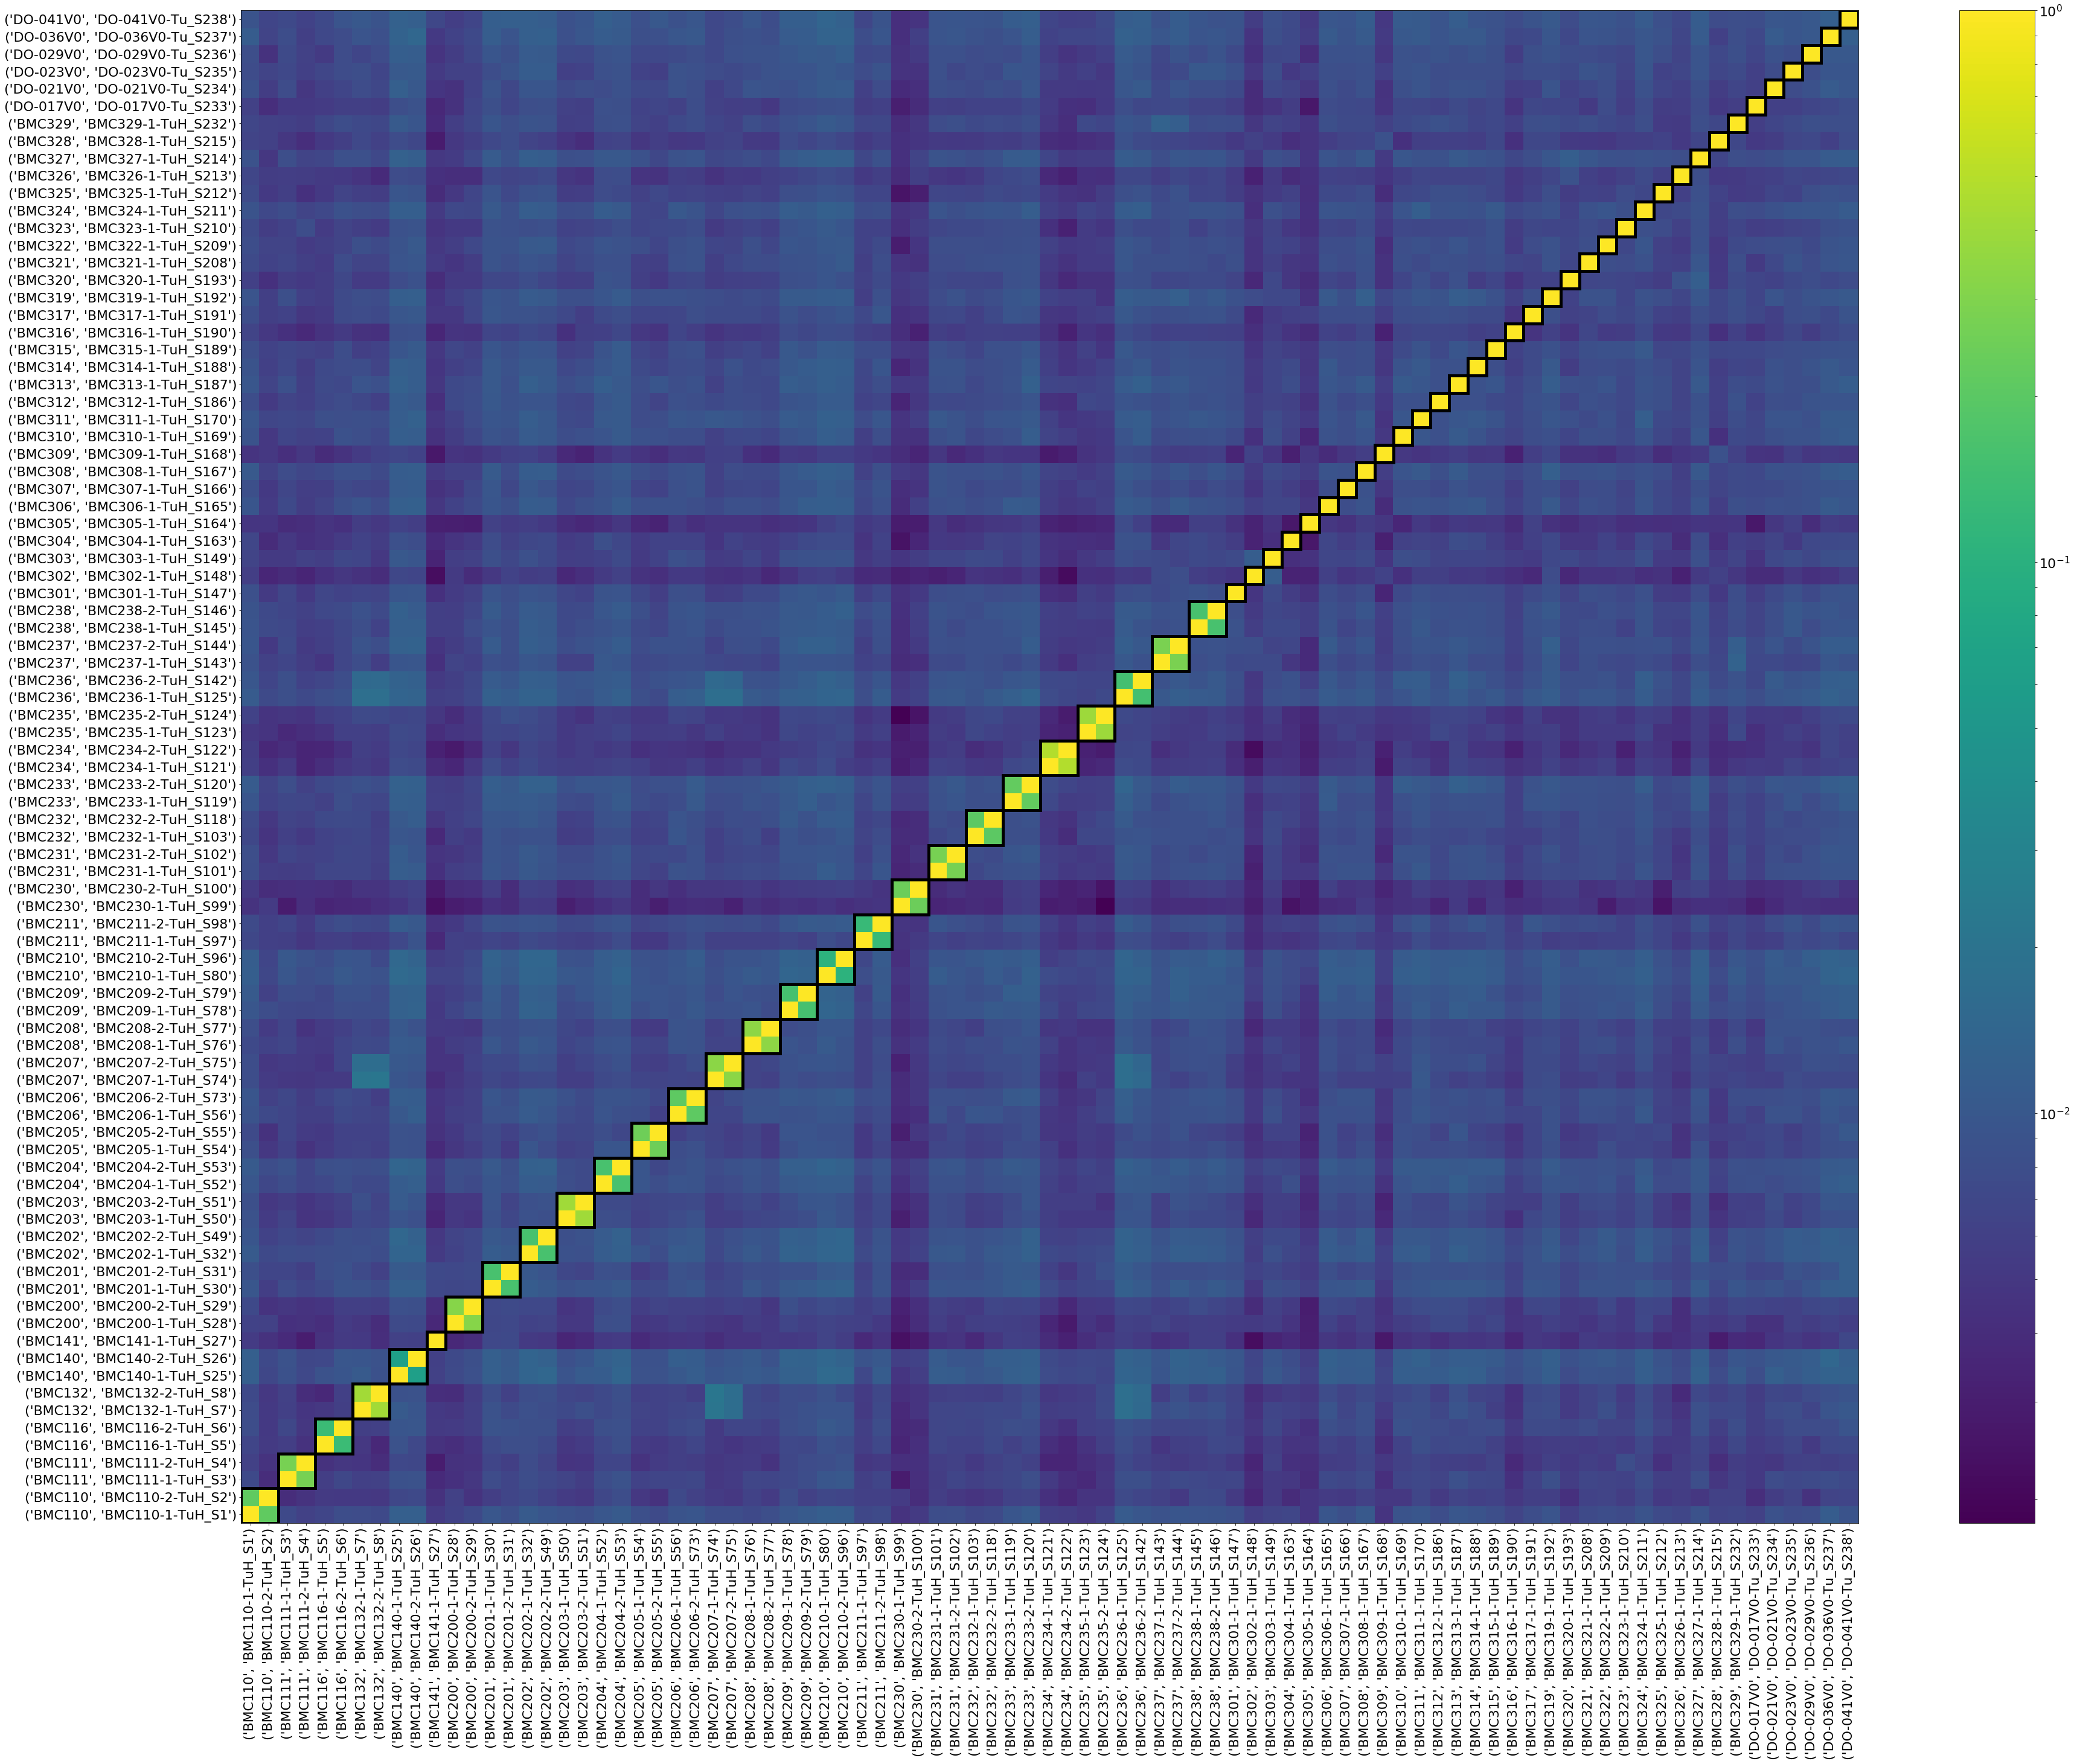

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.2402562047160845 0.10593471475614437
mean diff patient 0.007372120705549956 0.0022113344906893044
threshold 0.016217458668307174


{'whiskers': [<matplotlib.lines.Line2D at 0x7feae5694da0>,
 'caps': [<matplotlib.lines.Line2D at 0x7feae56986a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7feae5694c50>,
 'medians': [<matplotlib.lines.Line2D at 0x7feae5698ef0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7feae56a0358>,
 'means': []}

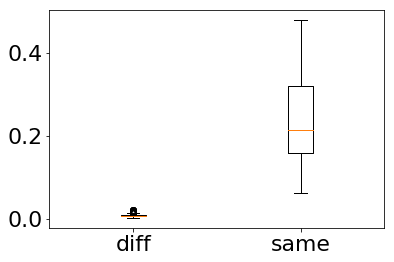

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

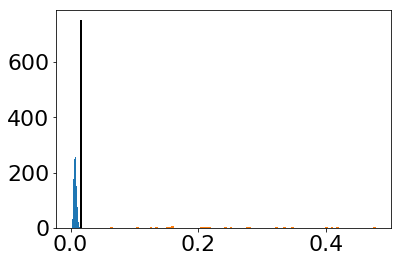

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('BMC132', 'BMC132-1-TuH_S7') ('BMC207', 'BMC207-1-TuH_S74') 0.02081934184016121
('BMC132', 'BMC132-1-TuH_S7') ('BMC207', 'BMC207-2-TuH_S75') 0.017052841912217565
('BMC132', 'BMC132-1-TuH_S7') ('BMC236', 'BMC236-1-TuH_S125') 0.01762320089013314
('BMC132', 'BMC132-2-TuH_S8') ('BMC207', 'BMC207-1-TuH_S74') 0.021542830099384735
('BMC132', 'BMC132-2-TuH_S8') ('BMC207', 'BMC207-2-TuH_S75') 0.01688068099841289
('BMC132', 'BMC132-2-TuH_S8') ('BMC236', 'BMC236-1-TuH_S125') 0.017704223996920954
('BMC207', 'BMC207-1-TuH_S74') ('BMC132', 'BMC132-1-TuH_S7') 0.02081934184016121
('BMC207', 'BMC207-1-TuH_S74') ('BMC132', 'BMC132-2-TuH_S8') 0.021542830099384735
('BMC207', 'BMC207-1-TuH_S74') ('BMC236', 'BMC236-1-TuH_S125') 0.01739427012278305
('BMC207', 'BMC207-2-TuH_S75') ('BMC132', 'BMC132-1-TuH_S7') 0.017052841912217565
('BMC207', 'BMC207-2-TuH_S75') ('BMC132', 'BMC132-2-TuH_S8') 0.01688068099841289
('BMC207', 'BMC207-2-TuH_S75') ('BMC236', 'BMC236-1-TuH_S125') 0.01723913890934292
('BMC236', 'BMC23

In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 0.0018075801749271037
max value: 1.0
Wrote run40-similarity-TRB_HUMAN-highlighted.pdf to disk


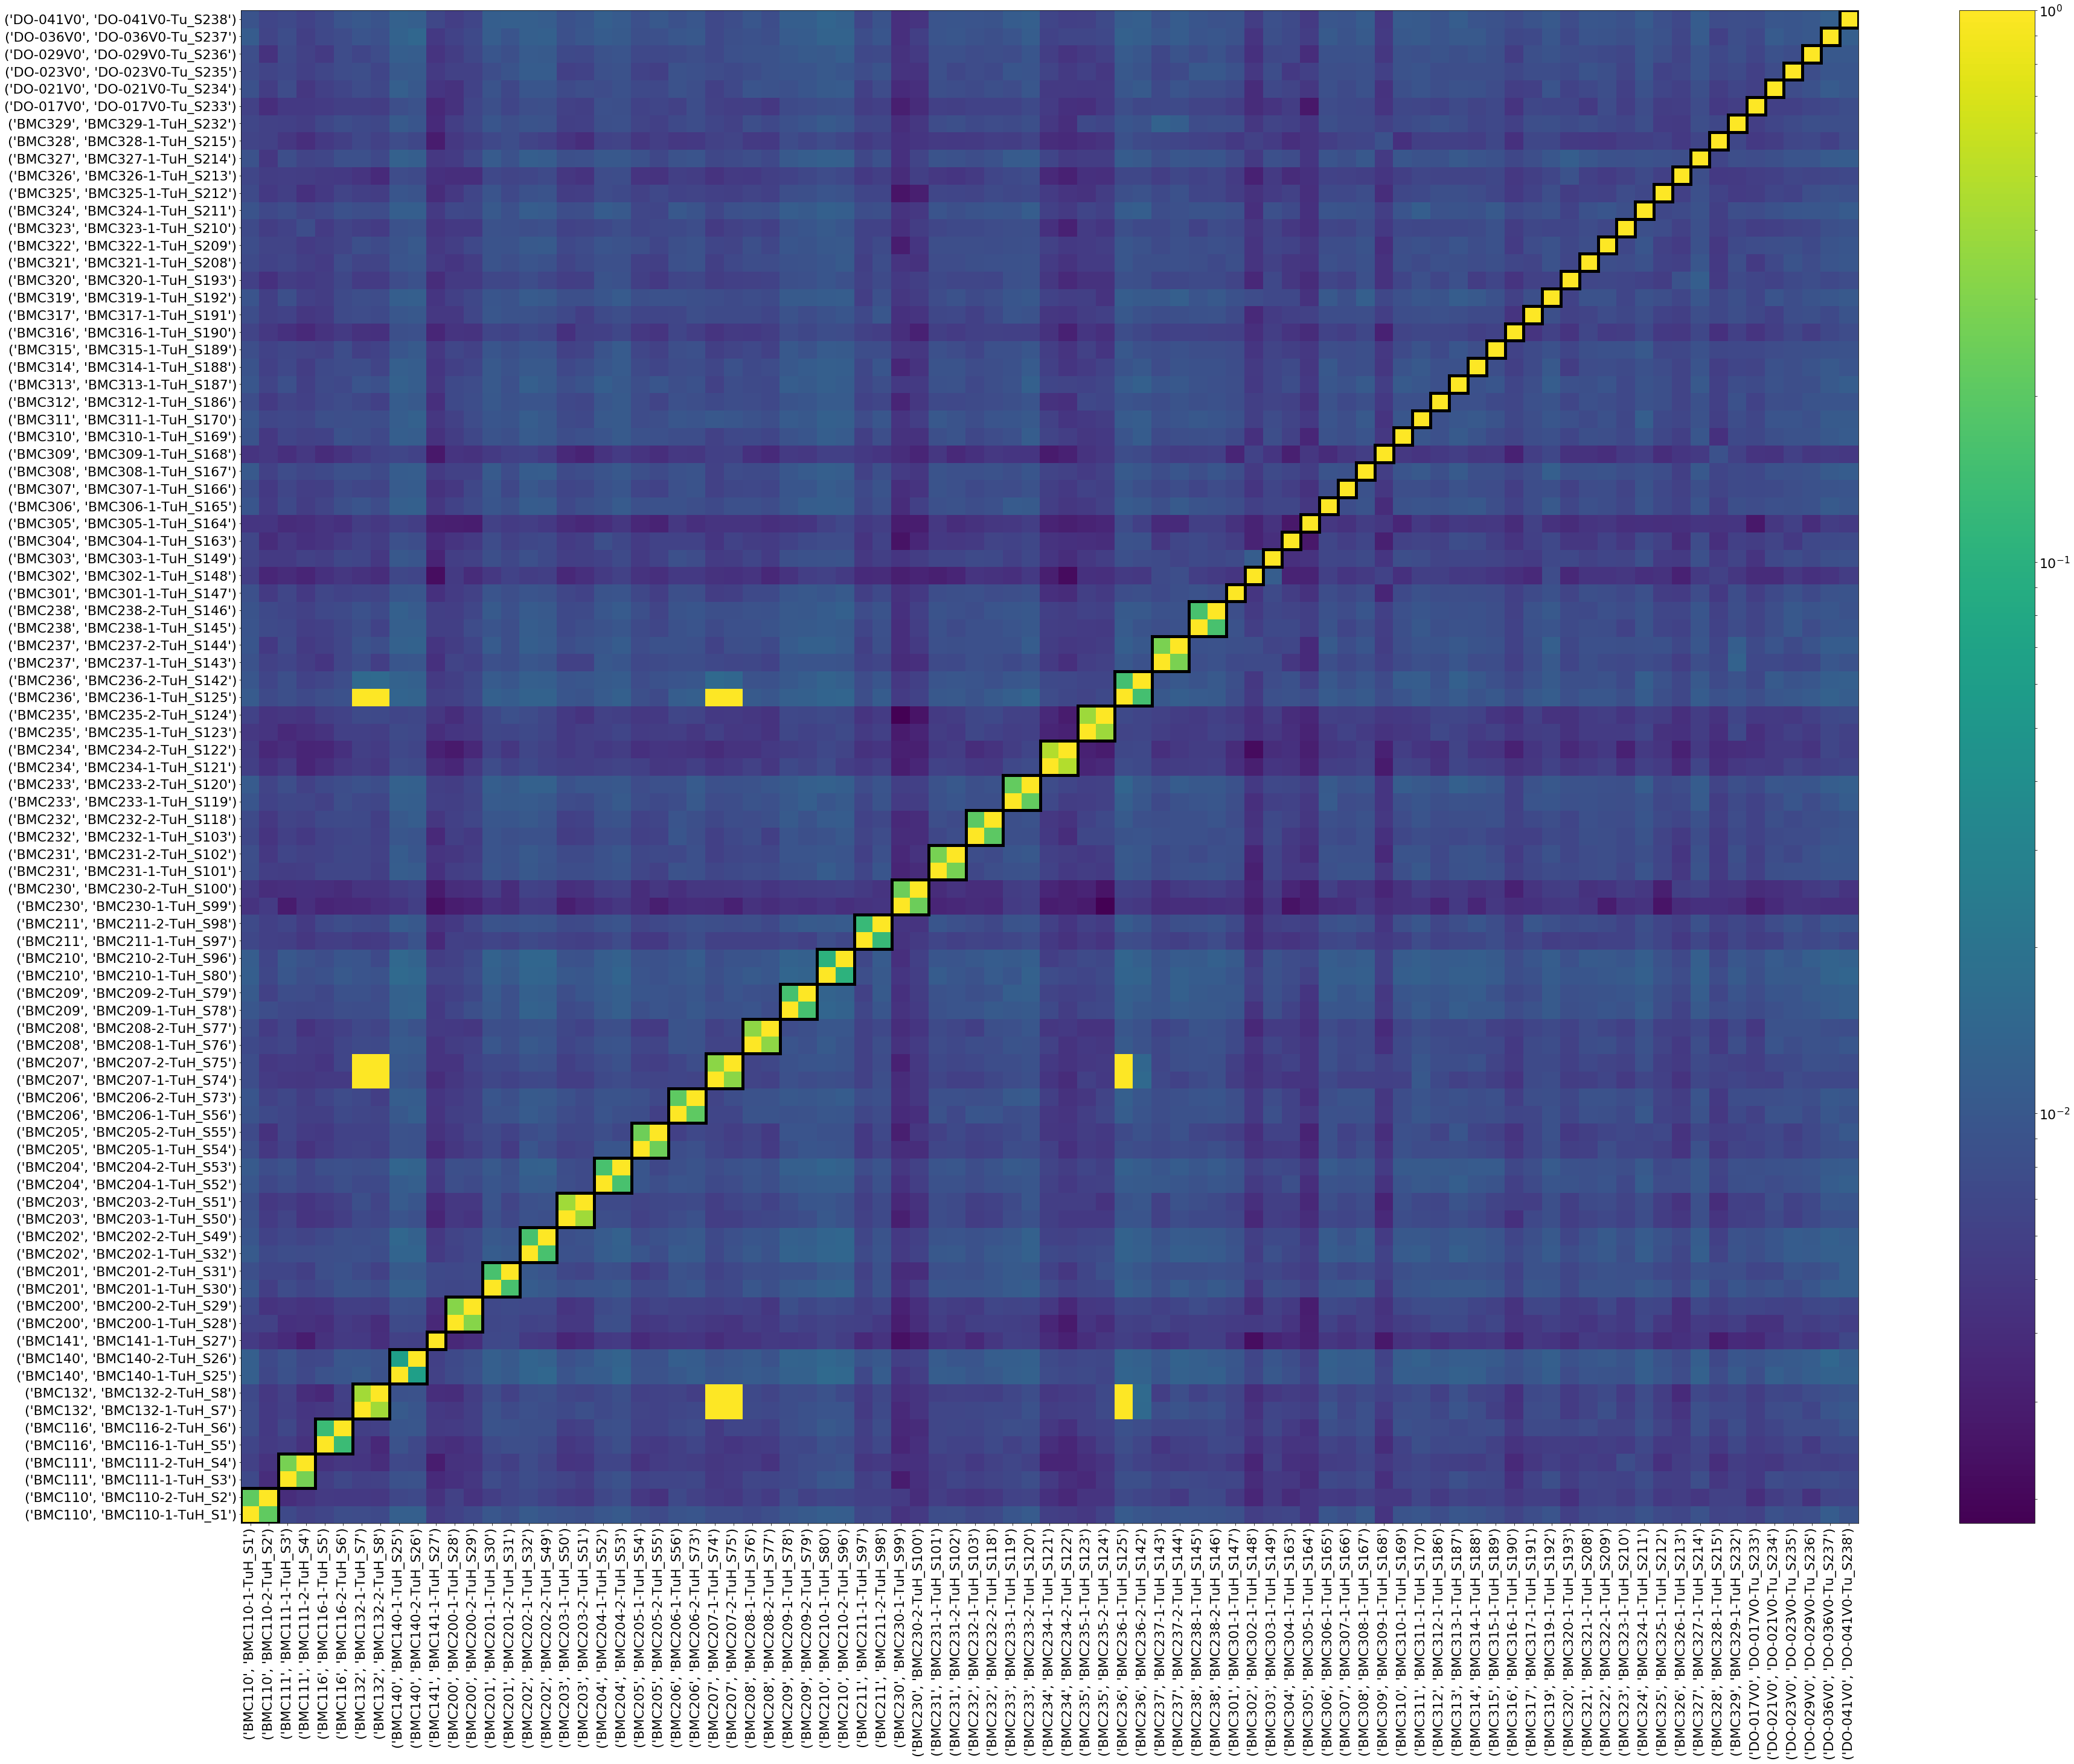

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)